# Welcome to the datalake course notebook!

For this course, I’ve created a few hands on exercises to help you get a feel for the considerations to take into account during each of the different steps when building a datalake.

Pretend that you are working with a University that has a Learning Management System.  In this University environment, students and instructors are accessing different pages for different courses several times a day.  Typically, student might be looking at online course content in modules, assignments or syllabus pages.  The activity generated by each user is being logged in a real time event stream.  

We are going to create a basic datalake using several source datasets.  We will ingest the datasets, clean and organize the data, then use the data to answer some questions.

Because our time together is short, and I didn’t want to create too many dependencies on cloud infrastructure, accounts, etc., I decided to go very simple with the notebook exercises and we will be using readily available python libraries.

Here are the first set of tasks to get set up for this environment:

1. Find and launch Binderhub and create a new notebook.
2. In the notebook, begin by importing the following libraries:
    - Pandas
    - Numpy
    - Matplotlib.pyplot 
3. Save and return to the class after you have completed these steps.


# Section 1 & 2 - Prepare Environment & Ingest Data

###### In this section, we first prepare the environment by importing the necessary python libraries which we will be using in this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.__version__

'1.1.4'

### For this next section, we will start to ingest data from our example source systems.  We have several datasets to work with:

    Courses: Information about courses available for students and teachers. 
    Users: Information about users accessing the learning management system. 
    Activity: An event log of activity taken by users in specific courses.

1. Read each of the dataset csv files into separate dataframes using the pandas library
2. Take a look through each source dataset once it has been ingested.
3. Save and return to the class after you have completed these steps.


###### The datasets are located in a folder named 'dataset' within this notebook environment as follows:
    dataset/courses.csv
    dataset/users.csv
    dataset/activity.csv

###### Use read_csv to read each csv file into local dataframes

In [2]:
courses_df=pd.read_csv("dataset/courses.csv")
users_df=pd.read_csv("dataset/users.csv")
activity_df=pd.read_csv('dataset/activity.csv',parse_dates=[0])

###### Now let's take a look at the layout of the data in each dataset.
    In courses, we have a course identifier, a title, description and other attributes about the course.
    
    In users, we have the userId along with other information such as the names, roles, and so on.
    
    The activity dataset is formatted as an event stream. Each row represents a unique event with a specific timestamp, along with actor, action and object triples.

In [3]:
courses_df.head()

courseId                       courseTitle  \
0         1           Introduction to Algebra   
1         2                       Biology 101   
2         3       Intro to Python Programming   
3         4  History of Ancient Civilizations   

                                         description academicSession      org  \
0  Fundamental concepts of algebra, including exp...        Fall2020     MATH   
1  Study of biology as it relates to humans and t...        Fall2020     BIOL   
2  A first course in computer programming using t...        Fall2020  COMPSCI   
3  In this course, we will study the emergence of...        Fall2020     HIST   

  modality  
0      f2f  
1   online  
2   hybrid  
3   hybrid

In [4]:
users_df.head()

userId FirstName LastName     Role                 email  year
0    1001       Tom    Grove  Learner      tgrove@email.edu   1.0
1    1002      Lily     Chen  Learner       lchen@email.edu   NaN
2    1003       Jim   Folsom  Learner  jim.folsom@email.edu   2.0
3    1004      Dan    Rivera  Learner  rivera_dan@email.edu   1.0
4    1005   Brenda     Ulloa  Learner     brendau@email.edu   NaN

In [5]:
activity_df.head()

timestamp  actor  action        object  course
0 2020-10-30 06:30:00   1001  viewed     /syllabus       2
1 2020-10-30 06:31:00   1001  viewed      /module1       2
2 2020-10-30 06:43:00   1001  viewed  /assignment1       2
3 2020-10-30 06:50:00   1001  viewed     /calendar       2
4 2020-10-31 10:10:20   1001  viewed     /syllabus       2

# Section 3 - Clean and Transform Data

###### In this section, we perform actions to clean and transform the data from our source systems.

For this next section, we will clean and organize the data which we have ingested into the datalake.

3a. Find and replace the null values in the users dataset.
3b. Classify the object column in the activity dataset and create a new ‘category’ column with the following mappings:
    - If object contains ‘module’, assign it to the ‘Module’ category
    - If object contains ‘assignment’, assign it to the ‘Assignment’ category
    - If object contains ‘syllabus’, assign it to the ‘Syllabus’ category
    - If object contains ‘calendar’, assign it to the ‘Calendar’ category
3c. Create a new dataframe by combining related dataframes (activity, user, course).  Use the keys as follows:
    - Left join activity with users on activity.actor=user.userId
    - Left join activity with courses on activity.course=courses.courseId

Save and return to the class after you have completed these steps.




# 3a - find and replace null values

###### Often raw source data have varying ways nulls may be present. Nulls need to be cleaned up here because many downstream systems do not understand how to process nulls.

In [6]:
users_df.isnull()

userId  FirstName  LastName   Role  email   year
0   False      False     False  False  False  False
1   False      False     False  False  False   True
2   False      False     False  False  False  False
3   False      False     False  False  False  False
4   False      False     False  False  False   True
5   False      False     False  False  False   True

###### Here, we replace nulls with a string constant of "No Year".

In [7]:
users_df["year"].fillna("No Year",inplace=True)

In [8]:
users_df.head()

userId FirstName LastName     Role                 email     year
0    1001       Tom    Grove  Learner      tgrove@email.edu        1
1    1002      Lily     Chen  Learner       lchen@email.edu  No Year
2    1003       Jim   Folsom  Learner  jim.folsom@email.edu        2
3    1004      Dan    Rivera  Learner  rivera_dan@email.edu        1
4    1005   Brenda     Ulloa  Learner     brendau@email.edu  No Year

In [9]:
activity_df.head()

timestamp  actor  action        object  course
0 2020-10-30 06:30:00   1001  viewed     /syllabus       2
1 2020-10-30 06:31:00   1001  viewed      /module1       2
2 2020-10-30 06:43:00   1001  viewed  /assignment1       2
3 2020-10-30 06:50:00   1001  viewed     /calendar       2
4 2020-10-31 10:10:20   1001  viewed     /syllabus       2

# 3b - map object values to categories 

###### Next, let's take the raw object value and classify it into known categories.

###### Here we create a dictionary to map the object values to categories. This map allows us to group multiple objects, such as different modules or assignments, into designated categories. This is a common way to roll up data for reporting purposes.

In [10]:
object_to_category_dict={"syllabus":"Syllabus", "module":"Module", "assignment":"Assignment","calendar":"Calendar"}

def object_to_category( objectStr ):
    for objectKey in object_to_category_dict.keys():
        if objectKey in objectStr:
            return object_to_category_dict[objectKey]
    return "Other"
activity_df['category']=activity_df['object'].apply( object_to_category )


###### Notice the new category column should now contain the value of the mapped category.

In [11]:
activity_df.head()

timestamp  actor  action        object  course    category
0 2020-10-30 06:30:00   1001  viewed     /syllabus       2    Syllabus
1 2020-10-30 06:31:00   1001  viewed      /module1       2      Module
2 2020-10-30 06:43:00   1001  viewed  /assignment1       2  Assignment
3 2020-10-30 06:50:00   1001  viewed     /calendar       2    Calendar
4 2020-10-31 10:10:20   1001  viewed     /syllabus       2    Syllabus

###### Here you can see multiple assignments grouped into the same "Assignment" category.

In [12]:
activity_df.tail()

timestamp  actor   action        object  course    category
40 2020-10-13 11:00:00   1006  updated     /syllabus       1    Syllabus
41 2020-10-14 11:00:00   1006  updated  /assignment1       1  Assignment
42 2020-10-15 11:00:00   1006  updated      /module1       1      Module
43 2020-10-16 11:00:00   1006  updated      /module2       1      Module
44 2020-10-17 11:00:00   1006  created  /assignment2       1  Assignment

# 3c - combine dataframes using keys

###### One of the most important ways to organize source data is by combining related datasets using known keys. 

    Here we join the activity dataframe with the related user information from the users dataset, as well as course information from the courses dataset. 

    For user information, we know that the actor column in the activity dataset refers to the userId from the user dataset. Therefore this is the key to use for the merged dataframe. 
    
    For course information, we know the course column in the activity dataset points to the courseId from the course dataset. 
    
    In both cases, we use a left join, because there may be users or courses listed in the source datasets that do not have corresponding activity records, therefore we do not want to include them in the merged dataframe.

In [13]:
new_df=activity_df.merge(users_df,left_on='actor', right_on='userId')

In [14]:
new_df

timestamp  actor   action        object  course    category  \
0  2020-10-30 06:30:00   1001   viewed     /syllabus       2    Syllabus   
1  2020-10-30 06:31:00   1001   viewed      /module1       2      Module   
2  2020-10-30 06:43:00   1001   viewed  /assignment1       2  Assignment   
3  2020-10-30 06:50:00   1001   viewed     /calendar       2    Calendar   
4  2020-10-31 10:10:20   1001   viewed     /syllabus       2    Syllabus   
5  2020-11-01 10:12:20   1001   viewed  /assignment1       2  Assignment   
6  2020-11-02 10:20:20   1001   viewed      /module1       2      Module   
7  2020-11-03 10:30:20   1001   viewed      /module2       2      Module   
8  2020-11-04 10:32:30   1001   viewed  /assignment2       2  Assignment   
9  2020-10-30 08:30:00   1002   viewed     /syllabus       2    Syllabus   
10 2020-10-30 08:31:00   1002   viewed      /module1       2      Module   
11 2020-10-30 08:43:00   1002   viewed  /assignment1       2  Assignment   
12 2020-10-30 08:50:00   1002   viewed     /calendar       2    Calendar   
13 2020-10-31 10:11:20   1002   viewed     /syllabus       2    Syllabus   
14 2020-11-01 10:14:20   1002   viewed  /assignment1       2  Assignment   
15 2020-11-02 10:50:20   1002   viewed      /module1       2      Module   
16 2020-11-03 10:56:20   1002   viewed      /module2       2      Module   
17 2020-11-04 11:30:30   1002   viewed  /assignment2       2  Assignment   
18 2020-10-30 06:30:00   1003   viewed     /syllabus       3    Syllabus   
19 2020-10-30 06:31:00   1003   viewed      /module1       3      Module   
20 2020-10-30 06:43:00   1003   viewed  /assignment1       3  Assignment   
21 2020-10-30 06:50:00   1003   viewed     /calendar       3    Calendar   
22 2020-10-31 10:10:20   1003   viewed     /syllabus       3    Syllabus   
23 2020-11-01 10:12:20   1003   viewed  /assignment1       3  Assignment   
24 2020-11-02 10:20:20   1003   viewed      /module1       3      Module   
25 2020-11-03 10:30:20   1003   viewed      /module2       3      Module   
26 2020-11-04 10:32:30   1003   viewed  /assignment2       3  Assignment   
27 2020-10-30 06:30:00   1004   viewed     /syllabus       3    Syllabus   
28 2020-10-30 06:31:00   1004   viewed      /module1       3      Module   
29 2020-10-30 06:43:00   1004   viewed  /assignment1       3  Assignment   
30 2020-10-30 06:50:00   1004   viewed     /calendar       3    Calendar   
31 2020-10-31 10:10:20   1004   viewed     /syllabus       3    Syllabus   
32 2020-11-01 10:12:20   1004   viewed  /assignment1       3  Assignment   
33 2020-11-02 10:20:20   1004   viewed      /module1       3      Module   
34 2020-11-03 10:30:20   1004   viewed      /module2       3      Module   
35 2020-11-04 10:32:30   1004   viewed  /assignment2       3  Assignment   
36 2020-10-09 11:00:00   1006  created     /syllabus       1    Syllabus   
37 2020-10-10 11:00:00   1006  updated      /module1       1      Module   
38 2020-10-11 11:00:00   1006  created  /assignment1       1  Assignment   
39 2020-10-12 11:00:00   1006  updated     /calendar       1    Calendar   
40 2020-10-13 11:00:00   1006  updated     /syllabus       1    Syllabus   
41 2020-10-14 11:00:00   1006  updated  /assignment1       1  Assignment   
42 2020-10-15 11:00:00   1006  updated      /module1       1      Module   
43 2020-10-16 11:00:00   1006  updated      /module2       1      Module   
44 2020-10-17 11:00:00   1006  created  /assignment2       1  Assignment   

    userId FirstName LastName        Role                 email     year  
0     1001       Tom    Grove     Learner      tgrove@email.edu        1  
1     1001       Tom    Grove     Learner      tgrove@email.edu        1  
2     1001       Tom    Grove     Learner      tgrove@email.edu        1  
3     1001       Tom    Grove     Learner      tgrove@email.edu        1  
4     1001       Tom    Grove     Learner      tgrove@email.edu        1  
5     1001       Tom    Grove     Learner      tgrove@email.edu   

In [15]:
new_df.merge(courses_df,left_on='course', right_on='courseId')

timestamp  actor   action        object  course    category  \
0  2020-10-30 06:30:00   1001   viewed     /syllabus       2    Syllabus   
1  2020-10-30 06:31:00   1001   viewed      /module1       2      Module   
2  2020-10-30 06:43:00   1001   viewed  /assignment1       2  Assignment   
3  2020-10-30 06:50:00   1001   viewed     /calendar       2    Calendar   
4  2020-10-31 10:10:20   1001   viewed     /syllabus       2    Syllabus   
5  2020-11-01 10:12:20   1001   viewed  /assignment1       2  Assignment   
6  2020-11-02 10:20:20   1001   viewed      /module1       2      Module   
7  2020-11-03 10:30:20   1001   viewed      /module2       2      Module   
8  2020-11-04 10:32:30   1001   viewed  /assignment2       2  Assignment   
9  2020-10-30 08:30:00   1002   viewed     /syllabus       2    Syllabus   
10 2020-10-30 08:31:00   1002   viewed      /module1       2      Module   
11 2020-10-30 08:43:00   1002   viewed  /assignment1       2  Assignment   
12 2020-10-30 08:50:00   1002   viewed     /calendar       2    Calendar   
13 2020-10-31 10:11:20   1002   viewed     /syllabus       2    Syllabus   
14 2020-11-01 10:14:20   1002   viewed  /assignment1       2  Assignment   
15 2020-11-02 10:50:20   1002   viewed      /module1       2      Module   
16 2020-11-03 10:56:20   1002   viewed      /module2       2      Module   
17 2020-11-04 11:30:30   1002   viewed  /assignment2       2  Assignment   
18 2020-10-30 06:30:00   1003   viewed     /syllabus       3    Syllabus   
19 2020-10-30 06:31:00   1003   viewed      /module1       3      Module   
20 2020-10-30 06:43:00   1003   viewed  /assignment1       3  Assignment   
21 2020-10-30 06:50:00   1003   viewed     /calendar       3    Calendar   
22 2020-10-31 10:10:20   1003   viewed     /syllabus       3    Syllabus   
23 2020-11-01 10:12:20   1003   viewed  /assignment1       3  Assignment   
24 2020-11-02 10:20:20   1003   viewed      /module1       3      Module   
25 2020-11-03 10:30:20   1003   viewed      /module2       3      Module   
26 2020-11-04 10:32:30   1003   viewed  /assignment2       3  Assignment   
27 2020-10-30 06:30:00   1004   viewed     /syllabus       3    Syllabus   
28 2020-10-30 06:31:00   1004   viewed      /module1       3      Module   
29 2020-10-30 06:43:00   1004   viewed  /assignment1       3  Assignment   
30 2020-10-30 06:50:00   1004   viewed     /calendar       3    Calendar   
31 2020-10-31 10:10:20   1004   viewed     /syllabus       3    Syllabus   
32 2020-11-01 10:12:20   1004   viewed  /assignment1       3  Assignment   
33 2020-11-02 10:20:20   1004   viewed      /module1       3      Module   
34 2020-11-03 10:30:20   1004   viewed      /module2       3      Module   
35 2020-11-04 10:32:30   1004   viewed  /assignment2       3  Assignment   
36 2020-10-09 11:00:00   1006  created     /syllabus       1    Syllabus   
37 2020-10-10 11:00:00   1006  updated      /module1       1      Module   
38 2020-10-11 11:00:00   1006  created  /assignment1       1  Assignment   
39 2020-10-12 11:00:00   1006  updated     /calendar       1    Calendar   
40 2020-10-13 11:00:00   1006  updated     /syllabus       1    Syllabus   
41 2020-10-14 11:00:00   1006  updated  /assignment1       1  Assignment   
42 2020-10-15 11:00:00   1006  updated      /module1       1      Module   
43 2020-10-16 11:00:00   1006  updated      /module2       1      Module   
44 2020-10-17 11:00:00   1006  created  /assignment2       1  Assignment   

    userId FirstName LastName        Role                 email     year  \
0     1001       Tom    Grove     Learner      tgrove@email.edu        1   
1     1001       Tom    Grove     Learner      tgrove@email.edu        1   
2     1001       Tom    Grove     Learner      tgrove@email.edu        1   
3     1001       Tom    Grove     Learner      tgrove@email.edu        1   
4     1001       Tom    Grove     Learner      tgrove@email.edu        1   
5     1001       Tom    Grove     Learner      tgrove@email.

# Section 5 - Use Data to Answer Questions

###### At this stage, the data is now organized in a way that makes it easier to use it to answer different questions.

Use the denormalized dataframe from the previous section to perform the following queries:
    5a. Top 5 pages (objects) accessed
        - List resulting rows
        - Create a horizontal bar chart
    5b. What activity took place on October 30, 2020?
        - Create a table listing the rows with activity
    5c. Which hour of the day had peak usage by category?
        - Create a line graph showing activity grouped by hour and category

Save and return to the class after you have completed these steps.


###### Since our activity data shows pages being accessed by different users in different courses, let's find out which pages were the most frequently accessed.

# 5a - Top 5 pages being accessed

###### We can use value_counts to check the frequency of each value, in this case, we want to check the pages accessed via the 'object' column.  In addition, we can build a simple bar graph to visualize this data.

In [16]:
new_df['object'].value_counts()[:5]

/syllabus       10
/module1        10
/assignment1    10
/module2         5
/calendar        5
Name: object, dtype: int64

<AxesSubplot:>

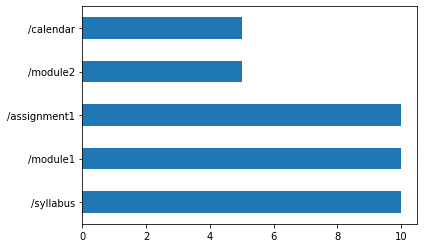

In [17]:
new_df['object'].value_counts()[:5].plot(kind='barh')

In [18]:
new_df.shape

(45, 12)

In [19]:
new_df.dtypes

timestamp    datetime64[ns]
actor                 int64
action               object
object               object
course                int64
category             object
userId                int64
FirstName            object
LastName             object
Role                 object
email                object
year                 object
dtype: object

###### Another common ad hoc query is to look at specific events that occurred on a specific day.

# 5b - What activity took place on Oct 30, 2020

In [20]:
new_df=new_df.set_index('timestamp') 

In [21]:
new_df.loc['2020-10-30']

actor  action        object  course    category  userId  \
timestamp                                                                      
2020-10-30 06:30:00   1001  viewed     /syllabus       2    Syllabus    1001   
2020-10-30 06:31:00   1001  viewed      /module1       2      Module    1001   
2020-10-30 06:43:00   1001  viewed  /assignment1       2  Assignment    1001   
2020-10-30 06:50:00   1001  viewed     /calendar       2    Calendar    1001   
2020-10-30 08:30:00   1002  viewed     /syllabus       2    Syllabus    1002   
2020-10-30 08:31:00   1002  viewed      /module1       2      Module    1002   
2020-10-30 08:43:00   1002  viewed  /assignment1       2  Assignment    1002   
2020-10-30 08:50:00   1002  viewed     /calendar       2    Calendar    1002   
2020-10-30 06:30:00   1003  viewed     /syllabus       3    Syllabus    1003   
2020-10-30 06:31:00   1003  viewed      /module1       3      Module    1003   
2020-10-30 06:43:00   1003  viewed  /assignment1       3  Assignment    1003   
2020-10-30 06:50:00   1003  viewed     /calendar       3    Calendar    1003   
2020-10-30 06:30:00   1004  viewed     /syllabus       3    Syllabus    1004   
2020-10-30 06:31:00   1004  viewed      /module1       3      Module    1004   
2020-10-30 06:43:00   1004  viewed  /assignment1       3  Assignment    1004   
2020-10-30 06:50:00   1004  viewed     /calendar       3    Calendar    1004   

                    FirstName LastName     Role                 email     year  
timestamp                                                                       
2020-10-30 06:30:00       Tom    Grove  Learner      tgrove@email.edu        1  
2020-10-30 06:31:00       Tom    Grove  Learner      tgrove@email.edu        1  
2020-10-30 06:43:00       Tom    Grove  Learner      tgrove@email.edu        1  
2020-10-30 06:50:00       Tom    Grove  Learner      tgrove@email.edu        1  
2020-10-30 08:30:00      Lily     Chen  Learner       lchen@email.edu  No Year  
2020-10-30 08:31:00      Lily     Chen  Learner       lchen@email.edu  No Year  
2020-10-30 08:43:00      Lily     Chen  Learner       lchen@email.edu  No Year  
2020-10-30 08:50:00      Lily     Chen  Learner       lchen@email.edu  No Year  
2020-10-30 06:30:00       Jim   Folsom  Learner  jim.folsom@email.edu        2  
2020-10-30 06:31:00       Jim   Folsom  Learner  jim.folsom@email.edu        2  
2020-10-30 06:43:00       Jim   Folsom  Learner  jim.folsom@email.edu        2  
2020-10-30 06:50:00       Jim   Folsom  Learner  jim.folsom@email.edu        2  
2020-10-30 06:30:00      Dan    Rivera  Learner  rivera_dan@email.edu        1  
2020-10-30 06:31:00      Dan    Rivera  Learner  rivera_dan@email.edu        1  
2020-10-30 06:43:00      Dan    Rivera  Learner  rivera_dan@email.edu        1  
2020-10-30 06:50:00      Dan    Rivera  Learner  rivera_dan@email.edu        1

###### Since the activity records were categorized in section 3 above, we can now perform queries and visualizations based on the resulting classified rows.

# 5c - Which hour of the day had peak usage by category? 

In [22]:
new_df[new_df['category'] == 'Syllabus']

actor   action     object  course  category  userId  \
timestamp                                                                  
2020-10-30 06:30:00   1001   viewed  /syllabus       2  Syllabus    1001   
2020-10-31 10:10:20   1001   viewed  /syllabus       2  Syllabus    1001   
2020-10-30 08:30:00   1002   viewed  /syllabus       2  Syllabus    1002   
2020-10-31 10:11:20   1002   viewed  /syllabus       2  Syllabus    1002   
2020-10-30 06:30:00   1003   viewed  /syllabus       3  Syllabus    1003   
2020-10-31 10:10:20   1003   viewed  /syllabus       3  Syllabus    1003   
2020-10-30 06:30:00   1004   viewed  /syllabus       3  Syllabus    1004   
2020-10-31 10:10:20   1004   viewed  /syllabus       3  Syllabus    1004   
2020-10-09 11:00:00   1006  created  /syllabus       1  Syllabus    1006   
2020-10-13 11:00:00   1006  updated  /syllabus       1  Syllabus    1006   

                    FirstName LastName        Role                 email  \
timestamp                                                                  
2020-10-30 06:30:00       Tom    Grove     Learner      tgrove@email.edu   
2020-10-31 10:10:20       Tom    Grove     Learner      tgrove@email.edu   
2020-10-30 08:30:00      Lily     Chen     Learner       lchen@email.edu   
2020-10-31 10:11:20      Lily     Chen     Learner       lchen@email.edu   
2020-10-30 06:30:00       Jim   Folsom     Learner  jim.folsom@email.edu   
2020-10-31 10:10:20       Jim   Folsom     Learner  jim.folsom@email.edu   
2020-10-30 06:30:00      Dan    Rivera     Learner  rivera_dan@email.edu   
2020-10-31 10:10:20      Dan    Rivera     Learner  rivera_dan@email.edu   
2020-10-09 11:00:00     Tammy  Teacher  Instructor      tteach@email.edu   
2020-10-13 11:00:00     Tammy  Teacher  Instructor      tteach@email.edu   

                        year  
timestamp                     
2020-10-30 06:30:00        1  
2020-10-31 10:10:20        1  
2020-10-30 08:30:00  No Year  
2020-10-31 10:11:20  No Year  
2020-10-30 06:30:00        2  
2020-10-31 10:10:20        2  
2020-10-30 06:30:00        1  
2020-10-31 10:10:20        1  
2020-10-09 11:00:00  No Year  
2020-10-13 11:00:00  No Year

###### First we create an index of the rows in the dataframe using the hour component of the timestamp column.

In [23]:
new_df.index.hour

Int64Index([ 6,  6,  6,  6, 10, 10, 10, 10, 10,  8,  8,  8,  8, 10, 10, 10, 10,
            11,  6,  6,  6,  6, 10, 10, 10, 10, 10,  6,  6,  6,  6, 10, 10, 10,
            10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11],
           dtype='int64', name='timestamp')

In [24]:
new_df['hour'] = new_df.index.hour

###### Next, we count the occurrences of each category within the hour.

In [25]:
counts = new_df[['hour','category']].groupby(['hour', 'category']).agg(len)

In [26]:
counts

hour  category  
6     Assignment    3
      Calendar      3
      Module        3
      Syllabus      3
8     Assignment    1
      Calendar      1
      Module        1
      Syllabus      1
10    Assignment    7
      Module        8
      Syllabus      4
11    Assignment    4
      Calendar      1
      Module        3
      Syllabus      2
dtype: int64

In [27]:
new_counts = counts.reset_index(['hour', 'category'])
new_counts.columns.values[-1] = 'Count'
new_counts

hour    category  Count
0      6  Assignment      3
1      6    Calendar      3
2      6      Module      3
3      6    Syllabus      3
4      8  Assignment      1
5      8    Calendar      1
6      8      Module      1
7      8    Syllabus      1
8     10  Assignment      7
9     10      Module      8
10    10    Syllabus      4
11    11  Assignment      4
12    11    Calendar      1
13    11      Module      3
14    11    Syllabus      2

###### Creating a pivot table allows us to set up the records to visualize via a graph.

In [28]:
new_counts_pivoted = pd.pivot_table(new_counts, values=['Count'], index=['hour'], columns=['category'], aggfunc=np.sum)

In [29]:
new_counts_pivoted

Count                         
category Assignment Calendar Module Syllabus
hour                                        
6               3.0      3.0    3.0      3.0
8               1.0      1.0    1.0      1.0
10              7.0      NaN    8.0      4.0
11              4.0      1.0    3.0      2.0

###### This graph shows the number of occurrences of each type of access by hour of the day.   From this graph, we can see that the 10 o clock hour is the most active across the board for all types of access.

<AxesSubplot:xlabel='hour'>

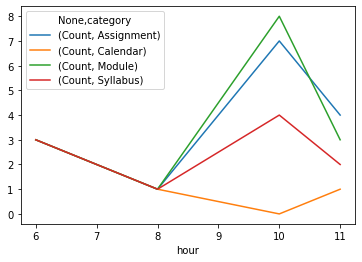

In [30]:
new_counts_pivoted.fillna(0.0).plot(kind='line')